## RLC Circuit using Physics Informed Neural Networks

This notebook was prepared for the project class of Inverse Problems. Here we reproduce the results obtained by Ben Mosely from ETH Zurih AI Center. https://github.com/benmoseley/harmonic-oscillator-pinn/tree/main

## Problem Statement

The problem to solve here is the 1D damped harmonic oscillator:
$$
L \dfrac{d^2 i}{d t^2} + R \dfrac{d t}{d t} + \dfrac{1}{C} i = 0~,
$$
with the initial conditions
$$
~~ L \dfrac{d i}{d t} = V_0 ~~ at ~~ t = 0.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\dfrac{R}{2L} < \dfrac{1}{\sqrt{LC}}~.
$$
This has the following exact solution:
$$
i(t) = \frac{V_0}{zL} e^{-\alpha t} \sin(zt)
~~~~~
\alpha = \frac{R}{2L}
~~~~~
z = \sqrt{\alpha^2 -\frac{1}{LC}}
$$

In [1]:
#Import Libraries
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
from torch.optim import Adam, LBFGS
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
from torch.optim import Adam, LBFGS

from PIL import Image
import os

import imageio

#### Analytical Solution - Under Damped Response

Here we are solving the analitical solution for the series connected RLC Circuit. 

In [2]:
R = torch.tensor([1.2])
L = torch.tensor([1.5])
C = torch.tensor([0.3])
V0 = torch.tensor([12])
z = torch.tensor([1.44])
alpha = torch.tensor([0.4])
t = torch.arange(0, 6.0, 1e-2).view(-1,1)

In [3]:
#define a function for the analytical solution
def underdamped_oscilator(R, L, C, V0, z, alpha, t):
    i = (V0/(z*L)) * torch.exp(-alpha * t) * torch.sin(z * t)
    return i

In [4]:
t.shape

torch.Size([600, 1])

In [5]:
#Compute the analytical Solution
analytical_sol = underdamped_oscilator(R, L, C, V0, z, alpha, t)
analytical_sol.shape

torch.Size([600, 1])

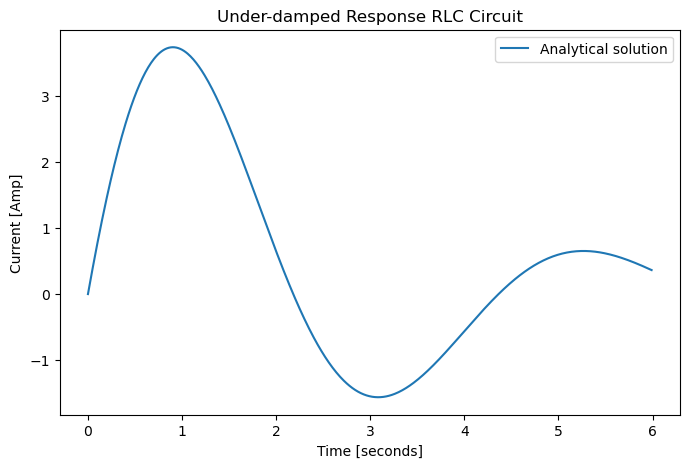

In [6]:
#Plot the anlytical solution
plt.figure(figsize=(8,5))
plt.plot(t, analytical_sol, label = 'Analytical solution')
plt.title('Under-damped Response RLC Circuit')
plt.xlabel('Time [seconds]')
plt.ylabel('Current [Amp]')
plt.legend()
plt.show()

#### Using PINN for the forward problem RLC Circuit

In [7]:
class FCN(nn.Module): # Forward


    def __init__(self, n_input = 1, n_nodes = 5, n_hl = 3, n_output = 1):

        super(FCN, self).__init__()
        layers = [nn.Linear(n_input, n_nodes), nn.GELU()]
        for _ in range(n_hl - 1):
            layers.append(nn.Linear(n_nodes, n_nodes))
            layers.append(nn.GELU())
        layers.append(nn.Linear(n_nodes, n_output))

        self.layers = nn.Sequential(*layers)
        #self.R = nn.Parameter(torch.randn(1, 1), requires_grad = True)
        #self.L = nn.Parameter(torch.randn(1, 1), requires_grad = True)
        #self.C = nn.Parameter(torch.randn(1, 1), requires_grad = True)

    def forward(self, x):
        return self.layers(x)


#t = torch.rand(4, 1)
model = FCN(n_input = 1, n_nodes = 128, n_hl = 2, n_output = 1)
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr = lr)

In [8]:
# slice out a small number of points from the LHS of the domain
t_data = t[0:600:15]
y_data = analytical_sol[0:600:15]
print(t_data.shape, y_data.shape)

torch.Size([40, 1]) torch.Size([40, 1])


In [9]:
# Define the collocation points
t_coloc = t_data
t_coloc.requires_grad = True
t_coloc = t_coloc.view(-1, 1)
t_init = torch.tensor([0.0], requires_grad = True)
i_init = torch.tensor([0.0], requires_grad = True)
t_init2 = torch.tensor([0.0], requires_grad = True)
v_init2 = torch.tensor([V0])
t_coloc.shape

torch.Size([40, 1])

In [10]:
def loss_data(model, coloc, y_true):
    #print(y_true.shape)
    out = model(coloc)
    #print(out.shape)
    return torch.mean((y_true - out)**2)

def loss_init_cond_1(model, t, x):
    out = model(t)
    return (out - x) ** 2

def loss_init_cond_2(model, x):
    global v_init2
    global L
    out = model(x)
    dfdx = grad(out, x, torch.ones_like(out), create_graph = True)[0]
    vl = dfdx * L
    return (vl - v_init2) ** 2

def loss_col_points(model, coloc):
    global R
    global L
    global C
    out = model(coloc)
    dfdx = grad(out, coloc, torch.ones_like(out), create_graph = True)[0]
    dfdx2 = grad(dfdx, coloc, torch.ones_like(dfdx), create_graph = True)[0]
    residual = dfdx2 + (R / L) * dfdx + out / (L * C)
    return residual ** 2 # sum of the residuals squared

def loss_init_cond_2_i(model, x):
    global v_init2
    out = model(x)
    dfdx = grad(out, x, torch.ones_like(out), create_graph = True)[0]
    vl = dfdx * model.L
    return (vl - v_init2) ** 2

def loss_i(model, coloc, response):
    out = model(coloc)
    return (out - response)**2

def loss_i_col_points(model, coloc):
    out = model(coloc)
    dfdx = grad(out, coloc, torch.ones_like(out), create_graph = True)[0]
    dfdx2 = grad(dfdx, coloc, torch.ones_like(dfdx), create_graph = True)[0]
    residual = dfdx2 + (model.R / model.L) * dfdx + out / (model.L * model.C)
    return residual ** 2 # sum of the residuals squared

def tr_step(model, coloc, t_init, t_init2, i_init, opt, y_true):

    opt.zero_grad()
    l1 = loss_init_cond_1(model, t_init, i_init)
    l2 = loss_init_cond_2(model, t_init2)
    l3 = loss_col_points(model, coloc)
    l4 = loss_data(model, coloc, y_true)
    l = l1 + 2*l2 + l3 + 10*l4

    l.backward()
    opt.step()
    return l.detach().numpy()


def tr_step_i(model, coloc, response, t_init, t_init2, i_init, opt, rlc = 1e-3):

    opt.zero_grad()
    l1 = loss_init_cond_1(model, t_init, i_init)
    l2 = loss_init_cond_2_i(model, t_init2)
    l3 = loss_i_col_points(model, coloc)
    l4 = loss_i(model, coloc, response)
    l = l1 + l2 + l3 + 10*l4

    l.backward()
    model.R.data.sub_(1e-3 * model.R.grad)
    model.L.data.sub_(1e-3 * model.L.grad)
    model.C.data.sub_(1e-3 * model.C.grad)
    model.R.grad.zero_()
    model.L.grad.zero_()
    model.C.grad.zero_()

    opt.step()
    return l.detach().numpy()



In [11]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="tab:green", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x_data.detach().numpy(), y_data.detach().numpy(), color="tab:blue", linewidth=2, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data.detach().numpy(), yh.detach().numpy(),s=60, color="tab:orange", alpha=0.4, label='Training data')
    #plt.scatter(x_data.detach().numpy(), y_data.detach().numpy(), s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    #plt.xlim(-0.05, 1.05)
    plt.ylim(-2, 4)
    plt.text(6.5, 1.9,"Training step: %i"%(epoch+1),fontsize="xx-large",color="k")
    plt.title('Under-damped Response RLC Circuit')
    plt.xlabel('Time [seconds]')
    plt.ylabel('Current [Amp]')
    #plt.axis("off")

Epoch 1, Loss:25.793964
Epoch 51, Loss:2.645558
Epoch 101, Loss:2.030869
Epoch 151, Loss:1.119820
Epoch 201, Loss:0.110874
Epoch 251, Loss:0.156161
Epoch 301, Loss:0.006186
Epoch 351, Loss:0.006213
Epoch 401, Loss:0.086942
Epoch 451, Loss:0.229659
Epoch 501, Loss:0.021727


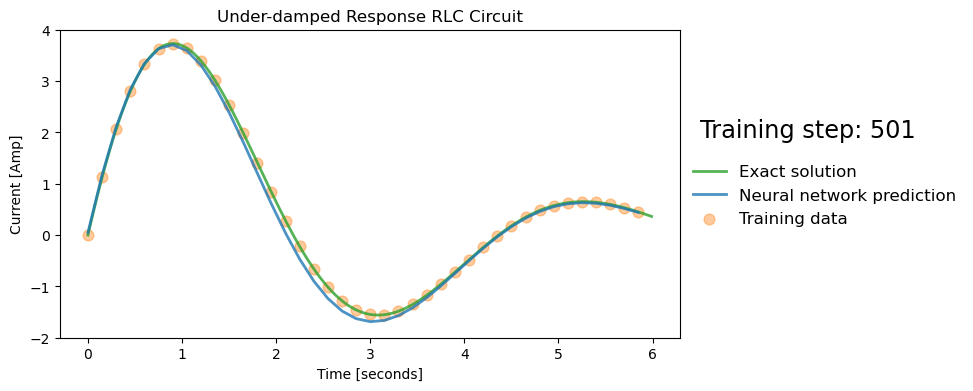

In [12]:
# train the PINN to solve the forward problem
# training loop
epochs = 501
tr_loss = []

for epoch in range(epochs):
    for point, y_true, in zip(t_coloc, y_data):
        
        l = tr_step(model, point, t_init, t_init2, i_init, opt, y_true)
        tr_loss.append(l)

    if epoch % 50 == 0:
        print(f"Epoch {epoch + 1}, Loss:{tr_loss[-1][0]:.6f}")

        yh = model(t_coloc).detach()

        plot_result(t, analytical_sol, t_coloc, yh, y_data)
        plt.savefig('gif_RLC/' + str(epoch) + '.png', bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  
        if (epoch+1) % 501 == 0: plt.show()
        else: plt.close("all")

 

In [13]:
def save_gif_PIL(outfile, files, loop=0):
    "Helper function for saving GIFs"
    #imgs = [Image(f'gif_RLC/{file}') for file in files if file.lower().endswith('.png')]
    imgs = [Image.fromarray(imageio.imread(f'gif_RLC/{file}')) for file in files if file.lower().endswith('.png')]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=500, loop=loop)

In [14]:
# Get the list of files and directories
files_and_dirs = os.listdir("gif_RLC")
files_and_dirs = [file for file in files_and_dirs if file.endswith('.png')]
# Sorting the list numerically
sorted_file_list = sorted(files_and_dirs, key=lambda x: int(x.split('.')[0]))
save_gif_PIL("RLC_circuit.gif", sorted_file_list, loop=0)

/var/folders/dk/lz3pdcm90wbbwyv9_l1tjq41p_gwfs/T/ipykernel_88695/3971654784.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [Image.fromarray(imageio.imread(f'gif_RLC/{file}')) for file in files if file.lower().endswith('.png')]


In [15]:
# Get the solution using PINN
y_pinn = model(t_coloc)

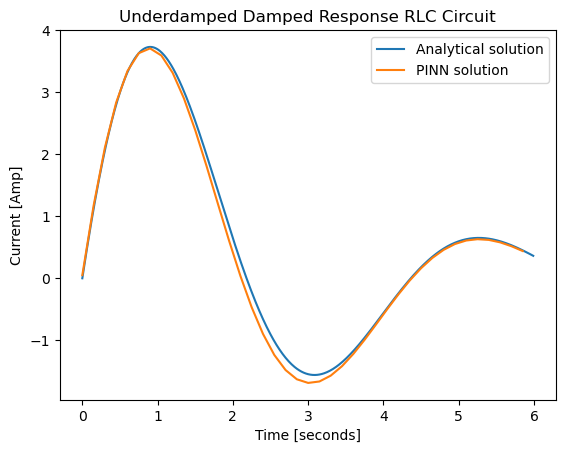

In [16]:
#Plot the anlytical solution
plt.plot(t, analytical_sol, label = 'Analytical solution')
plt.plot(t_coloc.detach().numpy(), y_pinn.detach().numpy(), label = 'PINN solution')
plt.title('Underdamped Damped Response RLC Circuit')
plt.xlabel('Time [seconds]')
plt.ylabel('Current [Amp]')
plt.legend()
plt.show()

#### Solving the Inverse Problem

In [17]:
class FCNI(nn.Module): # Forward

    def __init__(self, n_input = 1, n_nodes = 5, n_hl = 3, n_output = 1):

        super(FCNI, self).__init__()
        layers = [nn.Linear(n_input, n_nodes), nn.GELU()]
        for _ in range(n_hl - 1):
            layers.append(nn.Linear(n_nodes, n_nodes))
            layers.append(nn.GELU())
        layers.append(nn.Linear(n_nodes, n_output))

        self.layers = nn.Sequential(*layers)
        self.R = nn.Parameter(torch.tensor([0.1], requires_grad = True))
        self.L = nn.Parameter(torch.tensor([0.1], requires_grad = True))
        self.C = nn.Parameter(torch.tensor([0.1], requires_grad = True))

    def forward(self, x):
        return self.layers(x)

model_i = FCNI(n_input = 1, n_nodes = 128, n_hl = 2, n_output = 1)
opt = torch.optim.Adam(model_i.parameters(), lr = 1e-4)

new_data_points = y_pinn.detach().numpy()
#i_response = torch.tensor(new_data_points, requires_grad = True)
i_response = torch.tensor(y_data, requires_grad = True)

/var/folders/dk/lz3pdcm90wbbwyv9_l1tjq41p_gwfs/T/ipykernel_88695/3732243540.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  i_response = torch.tensor(y_data, requires_grad = True)


Epoch 1, loss: 141.894638
Epoch 51, loss: 2.058320
Epoch 101, loss: 1.351950
Epoch 151, loss: 3.747498
Epoch 201, loss: 3.102147
Epoch 251, loss: 2.313524
Epoch 301, loss: 1.661630
Epoch 351, loss: 1.119051
Epoch 401, loss: 0.690499
Epoch 451, loss: 0.341087
Epoch 501, loss: 0.098748


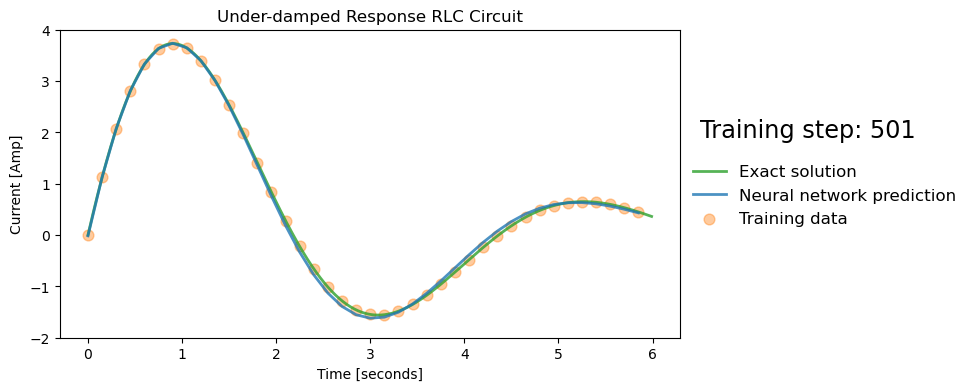

In [18]:
# training loop
epochs = 501
tr_loss = []

for epoch in range(epochs):
    for col, resp in zip(t_coloc, i_response):
        l = tr_step_i(model_i, col, resp, t_init, t_init2, i_init, opt)
        tr_loss.append(l)

    if epoch % 50 == 0:
        print(f"Epoch {epoch+ 1}, loss: {tr_loss[-1][0]:.6f}")

        yh = model_i(t_coloc).detach()

        plot_result(t, analytical_sol, t_coloc, yh, y_data)
        plt.savefig('gif_RLC_i/' + str(epoch) + '.png', bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  
        if (epoch+1) % 501 == 0: plt.show()
        else: plt.close("all")

In [19]:
R, L, C, model_i.R, model_i.L, model_i.C

(tensor([1.2000]),
 tensor([1.5000]),
 tensor([0.3000]),
 Parameter containing:
 tensor([1.2649], requires_grad=True),
 Parameter containing:
 tensor([1.4678], requires_grad=True),
 Parameter containing:
 tensor([0.3076], requires_grad=True))

In [20]:
# Get the list of files and directories
files_and_dirs_i = os.listdir("gif_RLC_i")
files_and_dirs_i = [file for file in files_and_dirs if file.endswith('.png')]
# Sorting the list numerically
sorted_file_list_i = sorted(files_and_dirs_i, key=lambda x: int(x.split('.')[0]))
save_gif_PIL("RLC_circuit_i.gif", sorted_file_list_i, loop=0)

/var/folders/dk/lz3pdcm90wbbwyv9_l1tjq41p_gwfs/T/ipykernel_88695/3971654784.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [Image.fromarray(imageio.imread(f'gif_RLC/{file}')) for file in files if file.lower().endswith('.png')]


In [21]:
# Get the solution using PINN
y_pinn_i = model_i(t_coloc)
y_pinn_i.shape

torch.Size([40, 1])

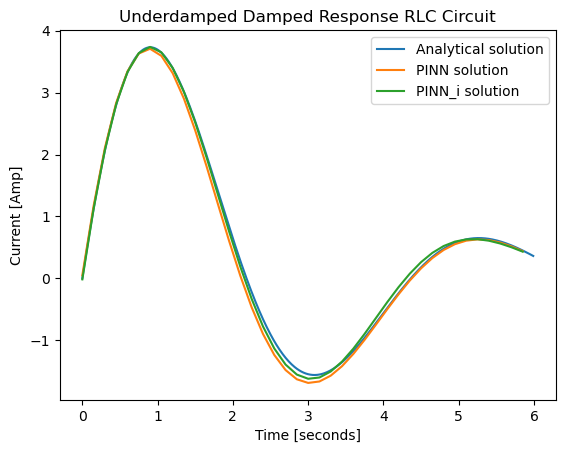

In [22]:
#Plot the anlytical solution
plt.plot(t, analytical_sol, label = 'Analytical solution')
plt.plot(t_coloc.detach().numpy(), y_pinn.detach().numpy(), label = 'PINN solution')
plt.plot(t_coloc.detach().numpy(), y_pinn_i.detach().numpy(), label = 'PINN_i solution')
plt.title('Underdamped Damped Response RLC Circuit')
plt.xlabel('Time [seconds]')
plt.ylabel('Current [Amp]')
plt.legend()
plt.show()

In [23]:
mse_pinn = torch.mean((y_pinn - y_data)**2)
mse_pinn

tensor(0.0132, grad_fn=<MeanBackward0>)

In [24]:
mse_pinn_i = torch.mean((y_pinn_i - y_data)**2)
mse_pinn_i

tensor(0.0036, grad_fn=<MeanBackward0>)

#### Solve Inverse Problems on Noisy Data

In [25]:
# generate a noisy data
noise_mean = 0.0
var_noise = 0.025
np.random.seed(123)
noise = np.random.normal(noise_mean, np.sqrt(var_noise), size = t_data.shape[0])
noise = torch.tensor(noise).view(-1,1)

noise.shape

torch.Size([40, 1])

In [26]:
i_response = torch.tensor(y_data + noise, requires_grad = True)

i_response.shape

/var/folders/dk/lz3pdcm90wbbwyv9_l1tjq41p_gwfs/T/ipykernel_88695/422382588.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  i_response = torch.tensor(y_data + noise, requires_grad = True)


torch.Size([40, 1])

In [27]:
model_noise = FCNI(n_input = 1, n_nodes = 128, n_hl = 2, n_output = 1)
opt = torch.optim.Adam(model_noise.parameters(), lr = 1e-4)

Epoch 1, loss: 149.481905
Epoch 51, loss: 2.453770
Epoch 101, loss: 1.645431
Epoch 151, loss: 2.629427
Epoch 201, loss: 2.263846
Epoch 251, loss: 1.946048
Epoch 301, loss: 1.662163
Epoch 351, loss: 1.398705
Epoch 401, loss: 1.165841
Epoch 451, loss: 0.962631
Epoch 501, loss: 0.783070


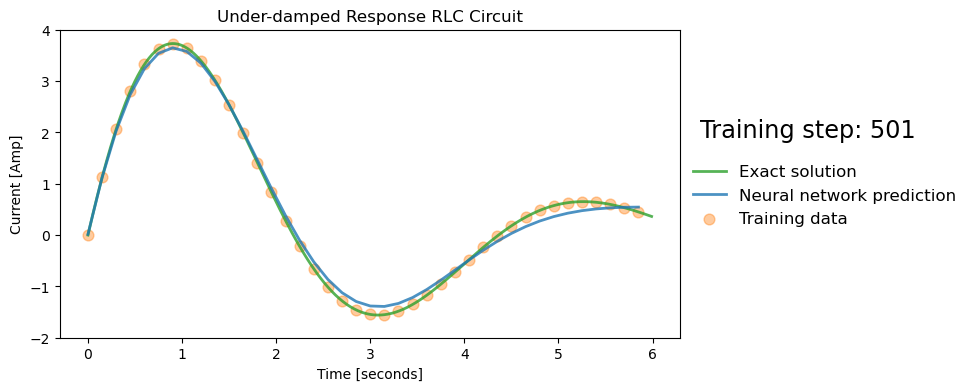

In [28]:
# training loop
epochs = 501
tr_loss = []

for epoch in range(epochs):
    for col, resp in zip(t_coloc, i_response):
        l = tr_step_i(model_noise, col, resp, t_init, t_init2, i_init, opt)
        tr_loss.append(l)

    if epoch % 50 == 0:
        print(f"Epoch {epoch+ 1}, loss: {tr_loss[-1][0]:.6f}")

        yh = model_noise(t_coloc).detach()

        plot_result(t, analytical_sol, t_coloc, yh, y_data)
        plt.savefig('gif_RLC_i/' + str(epoch) + '.png', bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  
        if (epoch+1) % 501 == 0: plt.show()
        else: plt.close("all")

In [30]:
# Get the solution using PINN
y_pinn_noise = model_noise(t_coloc)
y_pinn_noise.shape

torch.Size([40, 1])

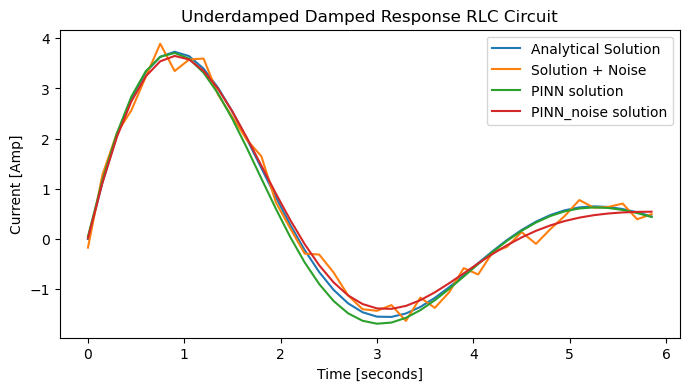

In [36]:
plt.figure(figsize=(8,4))
plt.plot(t_coloc.detach().numpy(), y_data, label = 'Analytical Solution')
plt.plot(t_coloc.detach().numpy(), i_response.detach().numpy(), label = 'Solution + Noise')
plt.plot(t_coloc.detach().numpy(), y_pinn.detach().numpy(), label = 'PINN solution')
plt.plot(t_coloc.detach().numpy(), y_pinn_noise.detach().numpy(), label = 'PINN_noise solution')
plt.legend()
plt.title('Underdamped Damped Response RLC Circuit')
plt.xlabel('Time [seconds]')
plt.ylabel('Current [Amp]')
plt.legend()
plt.show()

In [32]:
mse_pinn_noise = torch.mean((y_pinn_noise - y_data)**2)
mse_pinn_noise

tensor(0.0133, grad_fn=<MeanBackward0>)

In [33]:
R, L, C, model_noise.R, model_noise.L, model_noise.C

(tensor([1.2000]),
 tensor([1.5000]),
 tensor([0.3000]),
 Parameter containing:
 tensor([1.4000], requires_grad=True),
 Parameter containing:
 tensor([1.5152], requires_grad=True),
 Parameter containing:
 tensor([0.3362], requires_grad=True))